In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, SpectralEmbedding
from scipy import signal
import pandas as pd
import seaborn as sns

from sklearn.metrics import r2_score
import imp

from ikd import utils, core, evaluate, datasets
imp.reload(utils)
imp.reload(core)
imp.reload(evaluate)
imp.reload(datasets)


<module 'ikd.datasets' from '/storage/scratch1/1/cli726/ikd/ikd/ikd/datasets.py'>

Text(0.5, 1.0, 'True cov from $z$ to $x$')

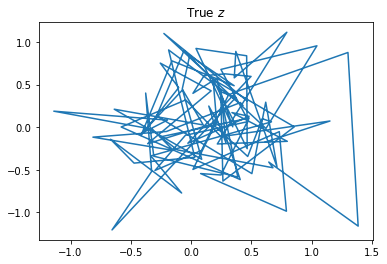

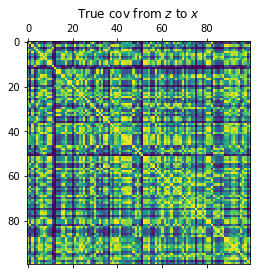

In [12]:
seed = 13
d_z = 2
n_points = 100
z_true = datasets.generate_latent_from_prior(d_z, n_points, 'autoregressive', 0.2, 1, 6, seed=seed)
plt.plot(z_true[:, 0], z_true[:, 1])
plt.title('True $z$')
variance_z = 1
length_scale_z = 0.7
cov_x_true = utils.kernel_cov_generator(z_true, variance=variance_z, length_scale=length_scale_z)
plt.matshow(cov_x_true)
plt.title('True cov from $z$ to $x$')

Text(0.5, 1.0, 'True cov from $x$ to $y$')

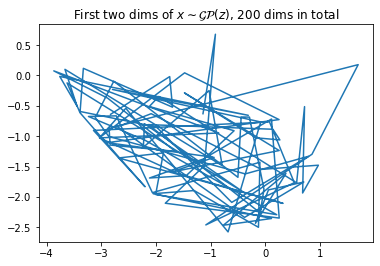

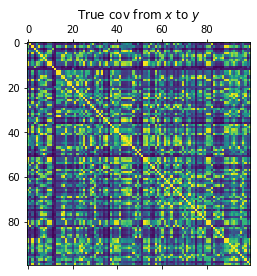

In [13]:
d_x = 200
x_true = datasets.gaussian_process_generator(cov_x_true, d_x, seed=seed)
plt.plot(x_true[:, 0], x_true[:, 1])
plt.title('First two dims of $x\\sim\\mathcal{GP}(z)$, 200 dims in total')
variance_x = 1
length_scale_x = 10
cov_y_true = utils.kernel_cov_generator(x_true, variance=variance_x, length_scale=length_scale_x)
plt.matshow(cov_y_true)
plt.title('True cov from $x$ to $y$')

Text(0.5, 1.0, 'Sample cov of $y$')

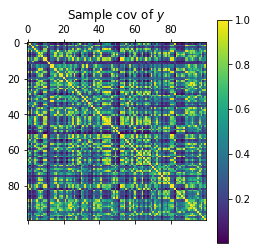

In [14]:
d_y = 200
y = datasets.gaussian_process_generator(cov_y_true, d_y, seed=seed)
# cov_y_samp = np.cov(y)
# variance_x_samp = np.mean(np.diag(cov_y_samp))
# cov_y_samp_th = utils.filt_cov_samp(cov_y_samp, variance=variance_x_samp)
cov_y_samp = np.corrcoef(y)
cov_y_samp_th = cov_y_samp.copy()
cov_y_samp_th[cov_y_samp_th <= 1e-3] = 1e-3
plt.matshow(cov_y_samp_th)
plt.colorbar()
plt.title('Sample cov of $y$')

Only one clique, identical to full eigen-decomposition
1.0


/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'Sample cov of $x$ recovered from $y$')

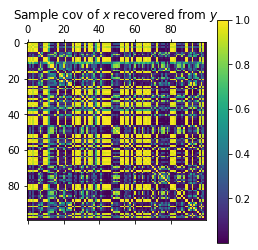

In [36]:
x_ikd = core.ikd_blockwise(cov_y_samp_th, d_x, variance=variance_x, length_scale=length_scale_x, clique_th_or_d_observation=d_y)
x_ikd_aligned = utils.align(x_true, x_ikd)
print(r2_score(x_true, x_ikd_aligned))

# cov_x_samp = np.cov(x_ikd)
# variance_z_samp = np.mean(np.diag(cov_x_samp))
# cov_x_samp_th = utils.filt_cov_samp(cov_x_samp, variance=variance_z_samp)
cov_x_samp = np.corrcoef(x_ikd)
cov_x_samp_th = cov_x_samp.copy()
cov_x_samp_th[cov_x_samp_th <= 1e-3] = 1e-3
np.nan_to_num(cov_x_samp_th, False, nan=1e-3)[0, -1]
plt.matshow(cov_x_samp_th)
plt.colorbar()
plt.title('Sample cov of $x$ recovered from $y$')
z_ikd = core.ikd_blockwise(cov_x_samp_th, d_z, variance=variance_z, length_scale=length_scale_z, clique_th_or_d_observation=d_x)
z_ikd_aligned = utils.align(z_true, z_ikd)
evaluate.compare_latents(z_true, z_ikd_aligned, 'IKD two steps')

Clique threshold: 0.2397940008672037, number of cliques: 121


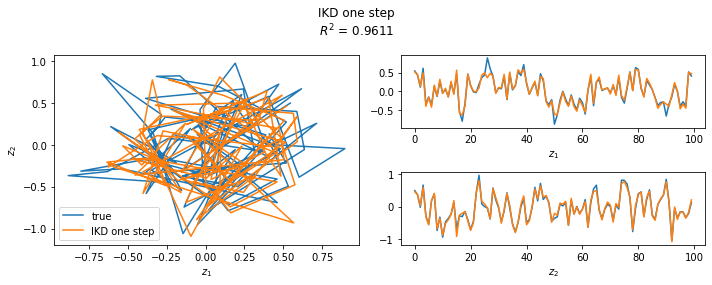

In [9]:
z_ikd = core.ikd_blockwise(cov_y_samp_th, d_z, clique_th_or_d_observation=d_y)
z_ikd_aligned = utils.align(z_true, z_ikd)
evaluate.compare_latents(z_true, z_ikd_aligned, 'IKD one step')

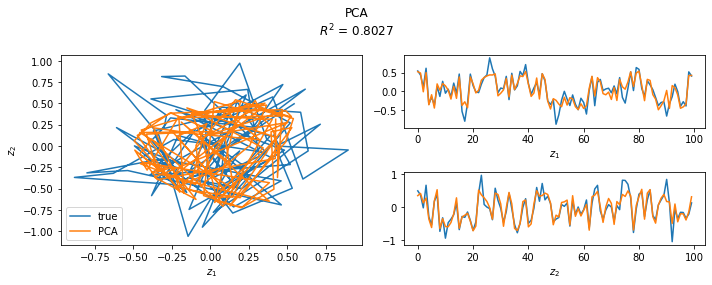

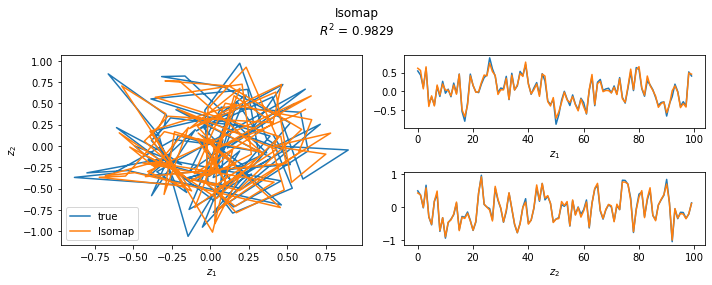

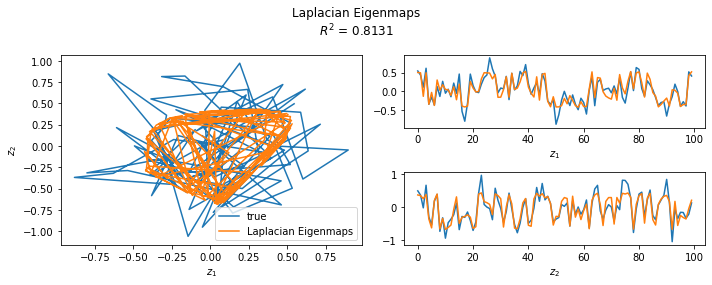

In [378]:
z_pca = PCA(n_components=d_z).fit_transform(y)
z_pca_aligned = utils.align(z_true, z_pca)
evaluate.compare_latents(z_true,  z_pca_aligned, 'PCA')

z_isomap = Isomap(n_components=d_z).fit_transform(y)
z_isomap_aligned = utils.align(z_true, z_isomap)
evaluate.compare_latents(z_true, z_isomap_aligned, 'Isomap')

z_le = SpectralEmbedding(n_components=d_z).fit_transform(y)
z_le_aligned = utils.align(z_true, z_le)
evaluate.compare_latents(z_true, z_le_aligned, 'Laplacian Eigenmaps')

## Experiment

In [37]:
df = pd.DataFrame(columns=['$R^2$', 'trial', 'method'])
for seed in range(50):
    d_z = 2
    n_points = 100
    z_true = datasets.generate_latent_from_prior(d_z, n_points, 'autoregressive', 0.2, 1, 6, seed=seed)
    variance_z = 1
    length_scale_z = 0.7
    cov_x_true = utils.kernel_cov_generator(z_true, variance=variance_z, length_scale=length_scale_z)
    
    d_x = 200
    x_true = datasets.gaussian_process_generator(cov_x_true, d_x, seed=seed)
    variance_x = 1
    length_scale_x = 10
    cov_y_true = utils.kernel_cov_generator(x_true, variance=variance_x, length_scale=length_scale_x)
    
    d_y = 200
    y = datasets.gaussian_process_generator(cov_y_true, d_y, seed=seed)
#     cov_y_samp = np.cov(y)
#     variance_x_samp = np.mean(np.diag(cov_y_samp))
#     cov_y_samp_th = utils.filt_cov_samp(cov_y_samp, variance=variance_x_samp)
    cov_y_samp = np.corrcoef(y)
    cov_y_samp_th = cov_y_samp.copy()
    cov_y_samp_th[cov_y_samp_th <= 1e-3] = 1e-3
    
    x_ikd = core.ikd_blockwise(cov_y_samp_th, d_x, variance=variance_x, length_scale=length_scale_x, clique_th_or_d_observation=d_y)
    x_ikd_aligned = utils.align(x_true, x_ikd)
#     print(r2_score(x_true, x_ikd_aligned))

#     cov_x_samp = np.cov(x_ikd)
#     variance_z_samp = np.mean(np.diag(cov_x_samp))
#     cov_x_samp_th = utils.filt_cov_samp(cov_x_samp, variance=variance_z_samp)
    cov_x_samp = np.corrcoef(x_ikd)
    cov_x_samp_th = cov_x_samp.copy()
    cov_x_samp_th[cov_x_samp_th <= 1e-3] = 1e-3
    np.nan_to_num(cov_x_samp_th, False, nan=1e-3)[0, -1]
    z_ikd = core.ikd_blockwise(cov_x_samp_th, d_z, variance=variance_z, length_scale=length_scale_z, clique_th_or_d_observation=d_x)
    z_ikd_aligned = utils.align(z_true, z_ikd)
    df.loc[5*seed + 0] = [r2_score(z_true, z_ikd_aligned), seed, 'IKD two steps']
    
    z_ikd = core.ikd_blockwise(cov_y_samp_th, d_z, clique_th_or_d_observation=d_y)
    z_ikd_aligned = utils.align(z_true, z_ikd)
    df.loc[5*seed + 1] = [r2_score(z_true, z_ikd_aligned), seed, 'IKD one steps']
    
    z_pca = PCA(n_components=d_z).fit_transform(y)
    z_pca_aligned = utils.align(z_true, z_pca)
    df.loc[5*seed + 2] = [r2_score(z_true, z_pca_aligned), seed, 'PCA']

    z_isomap = Isomap(n_components=d_z).fit_transform(y)
    z_isomap_aligned = utils.align(z_true, z_isomap)
    df.loc[5*seed + 3] = [r2_score(z_true, z_isomap_aligned), seed, 'Isomap']

    z_le = SpectralEmbedding(n_components=d_z).fit_transform(y)
    z_le_aligned = utils.align(z_true, z_le)
    df.loc[5*seed + 4] = [r2_score(z_true, z_le_aligned), seed, 'Laplacian Eigenmaps']
    
    print(seed)
    

Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [19 24]
Clique threshold: 0.2397940008672037, number of cliques: 6
Two cliques share less than (d+1) = 3 points.
Clique threshold: 0.2397940008672037, number of cliques: 136
0
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [26]
Clique threshold: 0.2397940008672037, number of cliques: 212
Clique threshold: 0.2397940008672037, number of cliques: 253
1
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [51]
Clique threshold: 0.2397940008672037, number of cliques: 18
Clique threshold: 0.2397940008672037, number of cliques: 208
2
Only one clique, identical to full eigen-decomposition
Clique threshold: 0.2397940008672037, number of cliques: 348
Clique threshold: 0.2397940008672037, number of cliques

/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/storage/home/hcoda1/1/cli726/.conda/envs/cli726/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Only one clique, identical to full eigen-decomposition
Clique threshold: 0.2397940008672037, number of cliques: 189
Clique threshold: 0.2397940008672037, number of cliques: 133
14
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [65]
Clique threshold: 0.2397940008672037, number of cliques: 108
Clique threshold: 0.2397940008672037, number of cliques: 246
15
Only one clique, identical to full eigen-decomposition
Only one clique, identical to full eigen-decomposition
Clique threshold: 0.2397940008672037, number of cliques: 214
16
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [58]
Clique threshold: 0.2397940008672037, number of cliques: 18
Clique threshold: 0.2397940008672037, number of cliques: 119
17
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining 

Clique threshold: 0.2397940008672037, number of cliques: 218
48
Only one clique, identical to full eigen-decomposition
Use nearest neighbors to find cliques that includes those remaining indices: [14]
Clique threshold: 0.2397940008672037, number of cliques: 5
Two cliques share less than (d+1) = 3 points.
Clique threshold: 0.2397940008672037, number of cliques: 162
49


<AxesSubplot:xlabel='method', ylabel='$R^2$'>

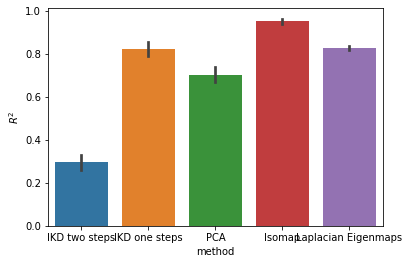

In [38]:
sns.barplot(y='$R^2$', x='method', data=df)

## 3D

Clique threshold: 0.2, number of cliques: 58


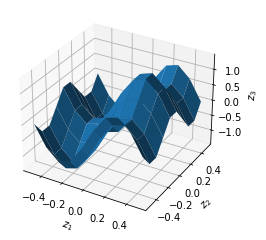

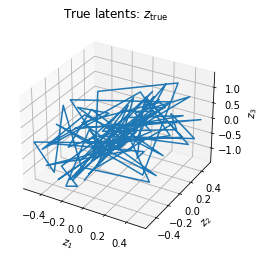

<Figure size 432x288 with 0 Axes>

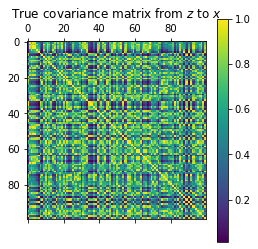

<Figure size 432x288 with 0 Axes>

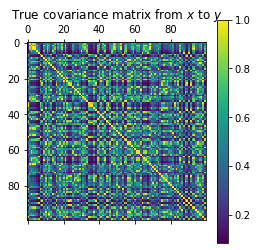

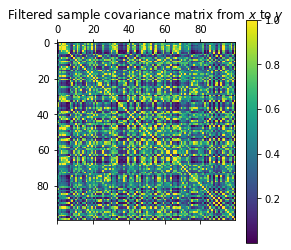

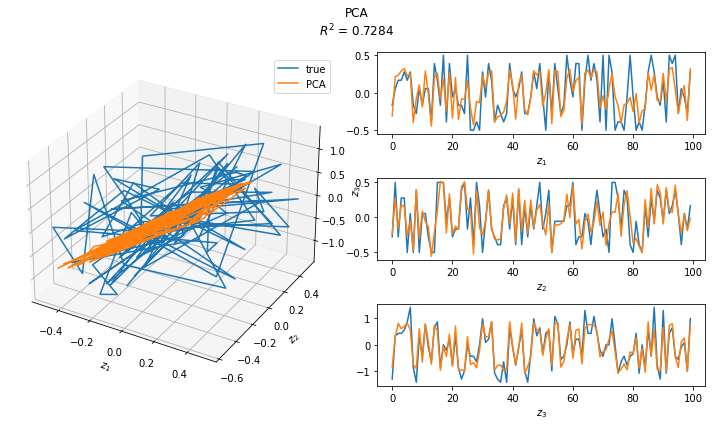

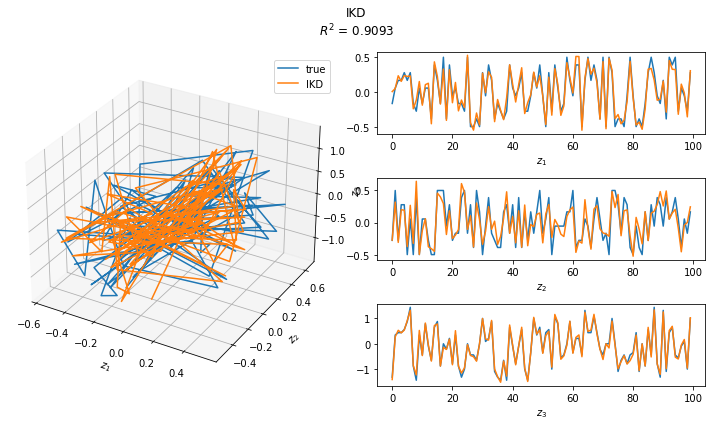

In [252]:
seed = 2
z_true = datasets.generate_latent(3, 2, n_points=100, show=True)
cov_1 = utils.kernel_cov_generator(z_true, show=True)
plt.title('True covariance matrix from $z$ to $x$')
x = datasets.gaussian_process_generator(cov_1, 200, seed=seed) / 10
cov_2 = utils.kernel_cov_generator(x, show=True)
plt.title('True covariance matrix from $x$ to $y$')
y = datasets.gaussian_process_generator(cov_2, 200, seed=seed)
cov_samp = np.cov(y)
cov_samp_th = utils.filt_cov_samp(cov_samp)
plt.matshow(cov_samp_th)
plt.colorbar()
plt.title('Filtered sample covariance matrix from $x$ to $y$')

z_pca = PCA(n_components=3).fit_transform(y)
evaluate.compare_latents(z_true, utils.align(z_true, z_pca), 'PCA')
z_ikd = core.ikd_blockwise(cov_samp_th, d_latent=3)
evaluate.compare_latents(z_true, utils.align(z_true, z_ikd), 'IKD')

In [39]:
a = np.random.normal(0, 1, size=(1000, 1000))

In [45]:
%timeit a[a <= 1e-3] = 1e-3

7.66 ms ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%timeit np.clip(a, a_min=1e-3, a_max=None)

981 µs ± 3.91 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
